In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datasets import DATASET_FULLNAMES

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

LABELS = {
    'auc': 'AUC',
    'accuracy': 'Accuracy',
    'f1': 'F1 Score',
    'gsup': '\#Support',
    'lsup': '\#LocalSupport',
    'rsup': 'Support Ratio',
}

RULE = [
    'LIRE',
    'RuleFit', 
    'GLRM',
]
COMPLEX = [
    'RF',
    'LightGBM', 
    'KernelSVM', 
]
METHODS = RULE + COMPLEX

DATASETS = [
    'a',
    'b',
    'h',
    'f',
    'c',
]

SCORE = 'accuracy'

In [2]:
def tradeoff(xs=['gsup'], ys=['auc'], dataset='a', C_lis=[1.0]):
    df = pd.read_csv('./res/tradeoff_{}.csv'.format(dataset))
    df_rf = df[df.method=='RF']
    df_rufi = df[df.method=='RuleFit']
    df_lire = dict([ (C_li, df[(df.method=='LIRE') & (df.C_li==C_li)]) for C_li in C_lis ])

    if len(xs) > len(ys):
        fig = plt.figure(figsize=(5 * len(xs), 3 * len(ys)))
    else:
        fig = plt.figure(figsize=(5 * len(xs), 2.25 * len(ys)))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            if len(xs) > len(ys):
                plt.subplot(len(ys), len(xs), i * len(ys) + j + 1)
            else:
                plt.subplot(len(ys), len(xs), i + j * len(xs) + 1)
            if df_rf[y].mean()!=-1:
                plt.axhline(y=df_rf[y].mean(), color='gray', linestyle='dashed', label='RF')
            for C_li in C_lis:
                plt.scatter(df_lire[C_li][x], df_lire[C_li][y], label='LIRE (ours)', marker='o', s=75)
            plt.scatter(df_rufi[x], df_rufi[y], label='RuleFit', marker='^', s=75)
            plt.xlabel(LABELS[x])
            plt.ylabel(LABELS[y])
            if len(xs) > len(ys):
                plt.legend(fontsize=12, loc='lower right')
            else:
                if i==0 and j==0:
                    plt.legend(fontsize=12, loc='lower right')

    plt.tight_layout()

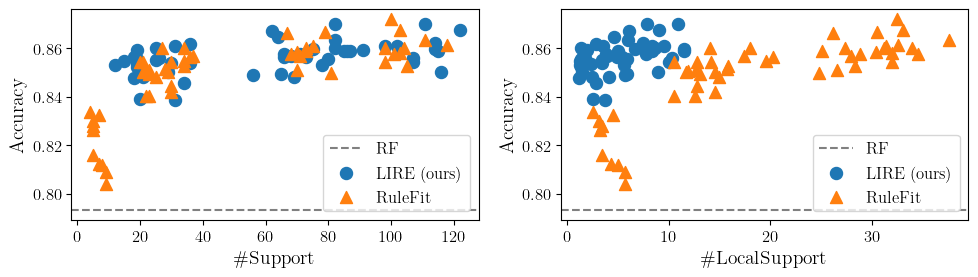

In [3]:
tradeoff(xs=['gsup', 'lsup'], ys=[SCORE], dataset='a', C_lis=[1.0])
plt.savefig('./fig/tradeoff_a.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/tradeoff_a.pdf', bbox_inches='tight', pad_inches=0.05)

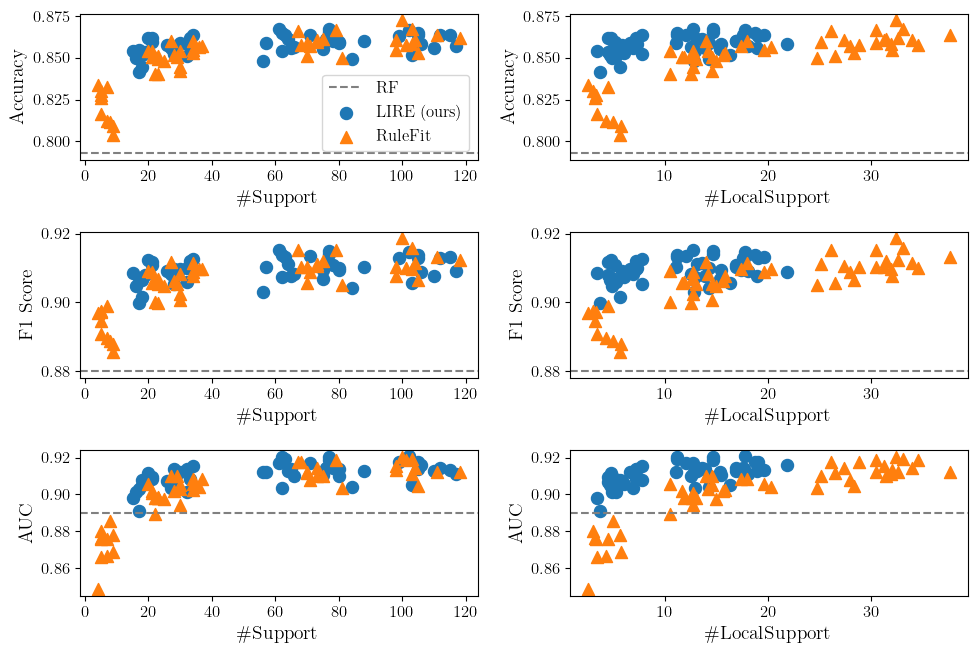

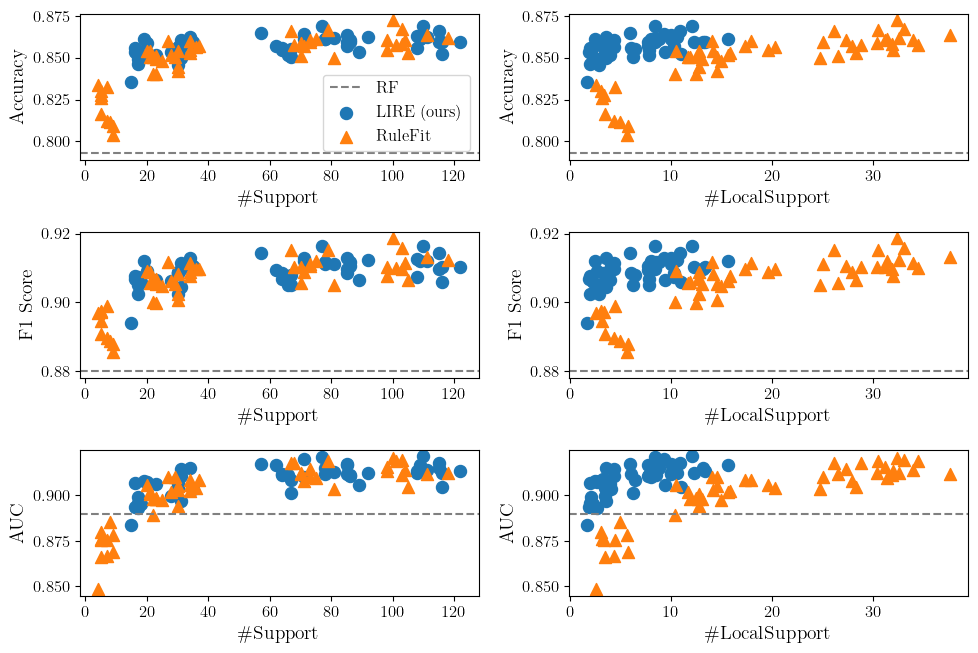

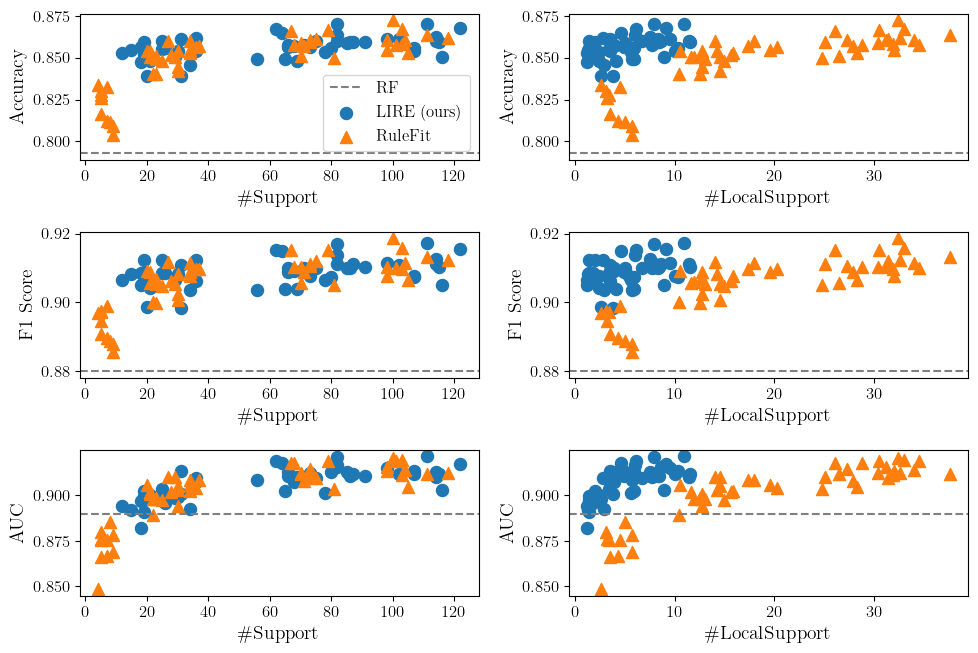

In [4]:
for C_li in [0.1, 0.5, 1.0]:
    tradeoff(xs=['gsup', 'lsup'], ys=['accuracy', 'f1', 'auc'], dataset='a', C_lis=[C_li])
    plt.savefig('./fig/tradeoff_appendix_{}_a.png'.format(C_li), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/tradeoff_appendix_{}_a.pdf'.format(C_li), bbox_inches='tight', pad_inches=0.05)

In [5]:
def sensitivity(ys=['auc'], dataset='a', C_l0s=[5e-4, 1e-3, 5e-3]):
    df = pd.read_csv('./res/tradeoff_{}.csv'.format(dataset))
    df_rf = df[df.method=='RF']
    df_lire = dict([ (C_l0, df[(df.method=='LIRE') & (df.C_l0==C_l0)]) for C_l0 in C_l0s ])
    C_lis = df.C_li.unique()[1:]
    if len(ys) > 3:
        h = 4
        w = int(len(ys) / 2)
    else:
        h = 1
        w = len(ys)
    fig = plt.figure(figsize=(3 * w, 3 * h))
    # plt.suptitle('{} dataset'.format(DATASET_FULLNAMES[dataset]))
    for i, y in enumerate(ys):
        plt.subplot(h, w, i + 1)
        if df_rf[y].mean()!=-1:
            plt.axhline(y=df_rf[y].mean(), color='gray', linestyle='dashed', label='RF')
        for C_l0 in C_l0s:
            plt.errorbar(C_lis, df_lire[C_l0].groupby('C_li')[y].mean(), df_lire[C_l0].groupby('C_li')[y].std(), 
                         label=r'$\gamma = {:.1}$'.format(C_l0), marker='o', markersize=7.5, capsize=3)
        plt.xlabel(r'$\lambda$')
        plt.ylabel(LABELS[y])
        plt.xscale('log')
        if i==0: plt.legend(fontsize=12, loc='lower left')
    plt.tight_layout()

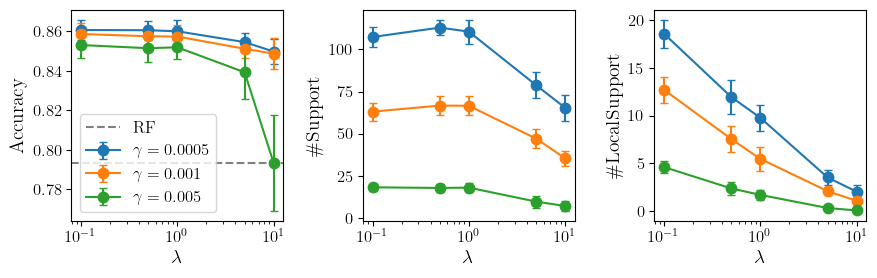

In [6]:
sensitivity(ys=[SCORE, 'gsup', 'lsup'], dataset='a', C_l0s=[5e-4, 1e-3, 5e-3])
plt.savefig('./fig/sensitivity_a.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/sensitivity_a.pdf', bbox_inches='tight', pad_inches=0.05)

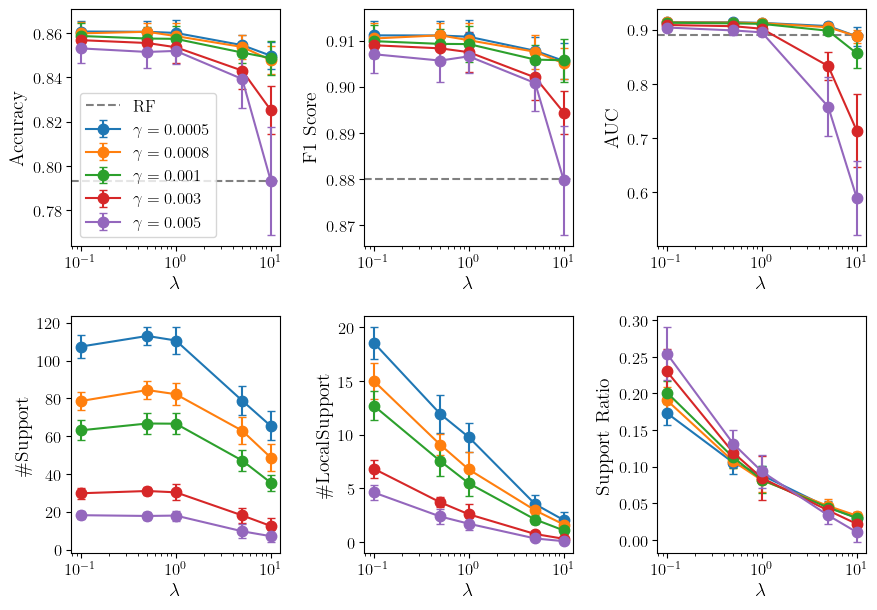

In [7]:
sensitivity(ys=['accuracy', 'f1', 'auc', 'gsup', 'lsup', 'rsup'], dataset='a', C_l0s=[5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3])
plt.savefig('./fig/sensitivity_appendix_a.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/sensitivity_appendix_a.pdf', bbox_inches='tight', pad_inches=0.05)

In [8]:
def comparison(y='auc', height=1.5):
    fig = plt.figure(figsize=(8, height * len(DATASETS)))
    for i, dataset in enumerate(DATASETS):
        plt.subplot(len(DATASETS), 1, i+1)
        df = pd.read_csv('./res/comparison_{}.csv'.format(dataset))
        df = pd.melt(pd.DataFrame(dict([(method + '\n (Avg.: {:.3})'.format(df[df.method==method][y].mean()), df[df.method==method][y].values) for method in METHODS])))
        sns.boxplot(x='variable', y='value', data=df, showfliers=False)
        sns.stripplot(x='variable', y='value', data=df, jitter=True, color='black')
        plt.title(DATASET_FULLNAMES[dataset], fontsize=13)
        plt.ylabel(LABELS[y])
        plt.xlabel('')
        plt.xticks(fontsize=10)
    plt.tight_layout()

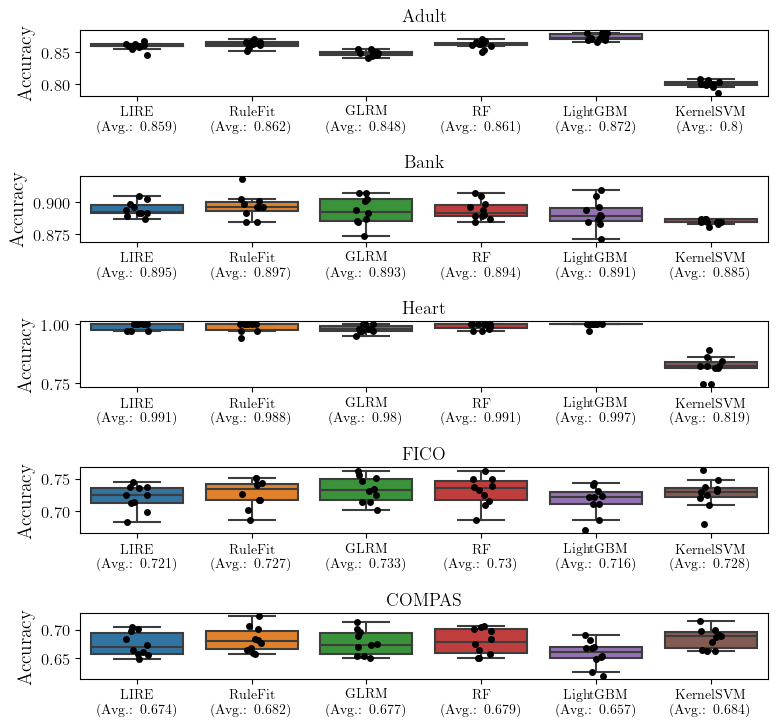

In [9]:
comparison(y=SCORE)
plt.savefig('./fig/comparison.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/comparison.pdf', bbox_inches='tight', pad_inches=0.05)

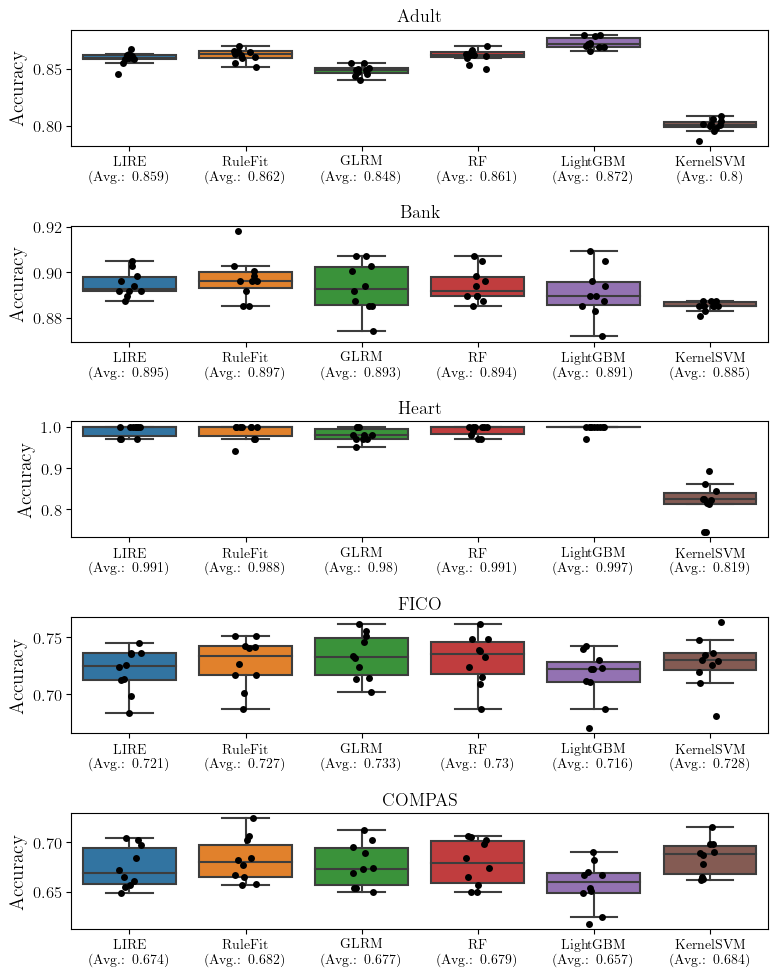

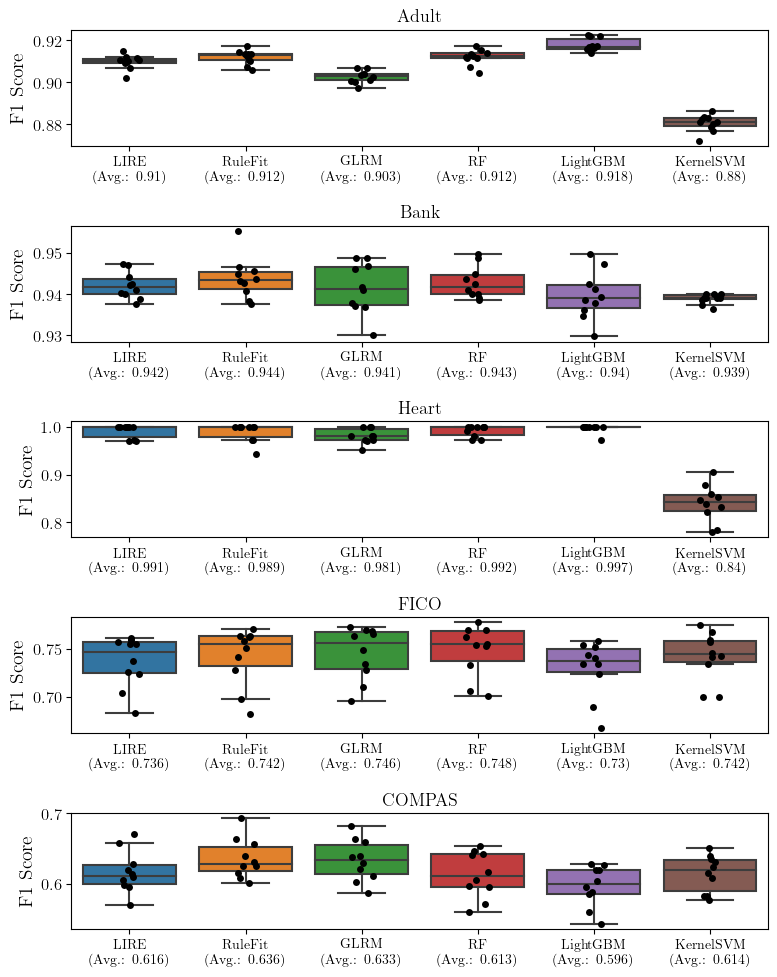

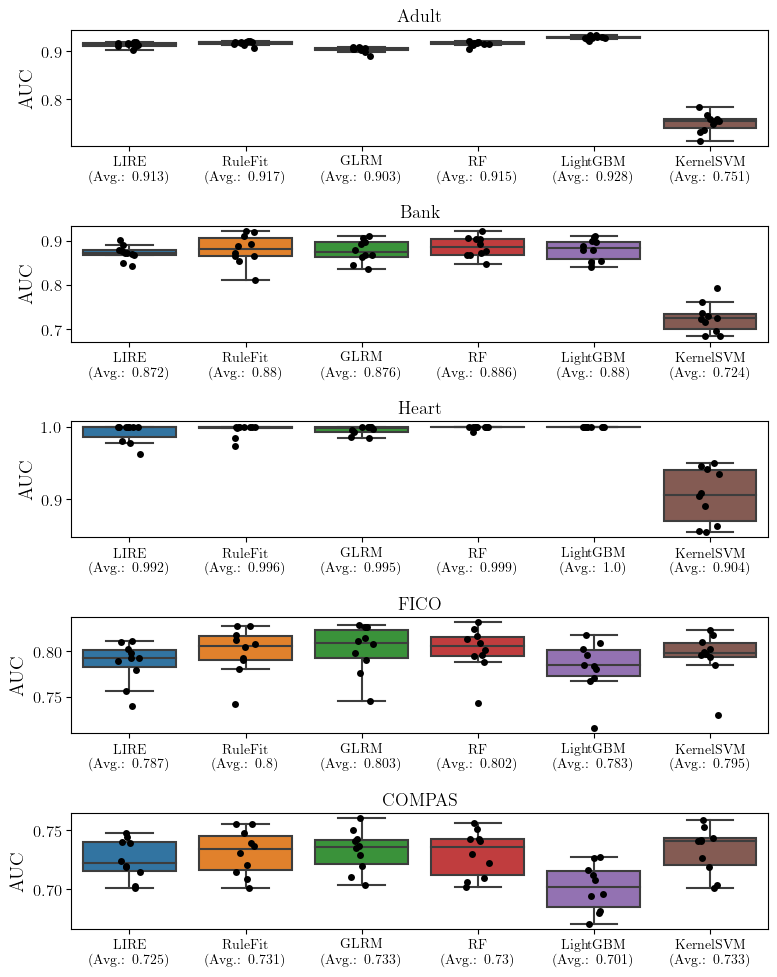

In [10]:
for score in ['accuracy', 'f1', 'auc']:
    comparison(y=score, height=2.0)
    plt.savefig('./fig/comparison_appendix_{}.png'.format(score), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('./fig/comparison_appendix_{}.pdf'.format(score), bbox_inches='tight', pad_inches=0.05)

In [11]:
def support(height=1.5):
    fig = plt.figure(figsize=(10, height * len(DATASETS)))
    for i, dataset in enumerate(DATASETS):
        for j, key in enumerate(['gsup', 'lsup', 'rsup']):
            plt.subplot(len(DATASETS), 3, 3*i+1 + j)
            df = pd.read_csv('./res/comparison_{}.csv'.format(dataset))
            df = pd.melt(pd.DataFrame(dict([(method, df[df.method==method][key].values) for method in RULE])))
            sns.boxplot(x='variable', y='value', data=df, showfliers=False)
            sns.stripplot(x='variable', y='value', data=df, jitter=True, color='black')
            plt.title(DATASET_FULLNAMES[dataset], fontsize=13)
            plt.xlabel('')
            plt.ylabel(LABELS[key], fontsize=12)
            # plt.xticks(fontsize=10)
    plt.tight_layout()

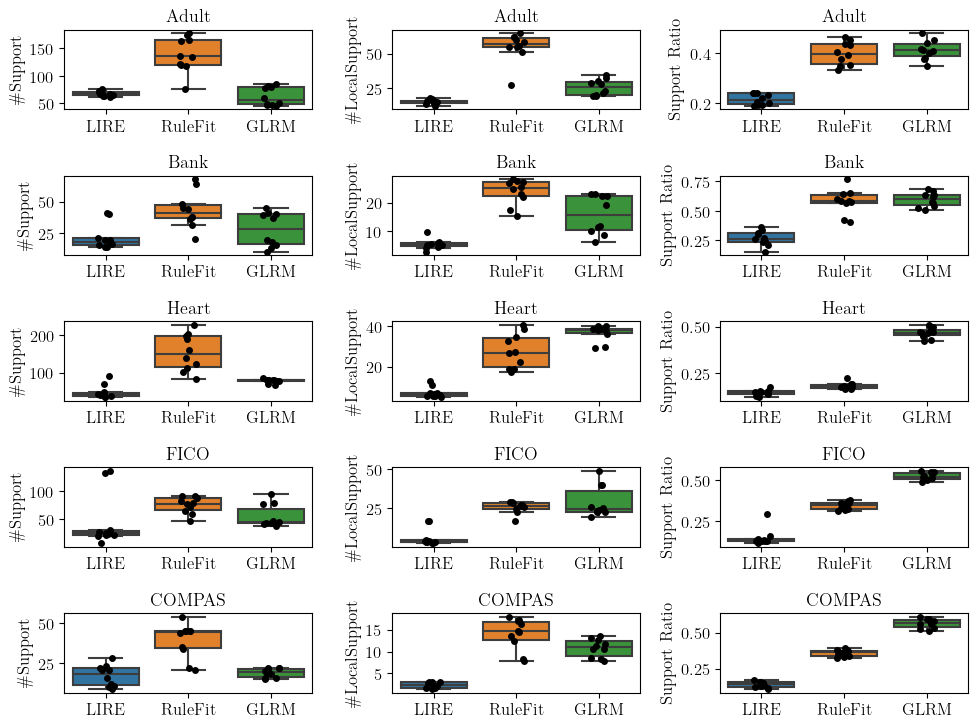

In [12]:
support()
plt.savefig('./fig/support.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/support.pdf', bbox_inches='tight', pad_inches=0.05)

In [13]:
def to_latex(key):
    avg = np.zeros((len(DATASETS), len(METHODS)))
    for i, dataset in enumerate(DATASETS):
        df = pd.read_csv('./res/comparison_{}.csv'.format(dataset))
        s = '{} '.format(DATASET_FULLNAMES[dataset])
        for j, method in enumerate(METHODS):
            s += '& ${} \pm {}$ '.format(df[df.method==method][key].mean().round(3), df[df.method==method][SCORE].std().round(2))
            avg[i, j] = df[df.method==method][key].mean()
        s += '\\\\'
        print(s)

    rnk = np.argsort(avg, axis=1) + 1
    s = 'Avg. '
    for a, r in zip(avg.T, rnk.T):
        s += '& {} ({})'.format(a.mean().round(3), r.mean().round(2))
    print(s)

to_latex('time')

Adult & $148.508 \pm 0.01$ & $9.658 \pm 0.01$ & $75.93 \pm 0.0$ & $5.137 \pm 0.01$ & $0.192 \pm 0.0$ & $401.712 \pm 0.01$ \\
Bank & $8.446 \pm 0.01$ & $1.308 \pm 0.01$ & $11.775 \pm 0.01$ & $0.825 \pm 0.01$ & $0.252 \pm 0.01$ & $2.017 \pm 0.0$ \\
Heart & $4.859 \pm 0.01$ & $0.782 \pm 0.02$ & $32.367 \pm 0.02$ & $0.095 \pm 0.01$ & $0.067 \pm 0.01$ & $0.106 \pm 0.05$ \\
FICO & $74.591 \pm 0.02$ & $1.93 \pm 0.02$ & $14.174 \pm 0.02$ & $2.142 \pm 0.02$ & $0.284 \pm 0.02$ & $10.991 \pm 0.02$ \\
COMPAS & $9.875 \pm 0.02$ & $1.191 \pm 0.02$ & $2.528 \pm 0.02$ & $0.492 \pm 0.02$ & $0.084 \pm 0.02$ & $4.468 \pm 0.02$ \\
Avg. & 49.256 (5.0)& 2.974 (3.6)& 27.355 (3.2)& 1.738 (4.0)& 0.176 (2.4)& 83.859 (2.8)


In [88]:
from scipy.stats import wilcoxon
import warnings
warnings.simplefilter('ignore')

def wilcoxon_test(key='accuracy'):
    for i, dataset in enumerate(DATASETS):
        df = pd.read_csv('./res/comparison_{}.csv'.format(dataset))
        x = df[df.method=='LIRE'][key].values
        if 'sup' not in key:
            methods = METHODS[1:]
        else:
            methods = RULE[1:]
        s = '{} '.format(DATASET_FULLNAMES[dataset])
        for j, method in enumerate(methods):
            y = df[df.method==method][key].values
            if 'sup' not in key:
                _, p = wilcoxon(x, y, alternative='less')
            else:
                _, p = wilcoxon(x, y, alternative='greater')
            # print('\t{:10} {:<6} {} {} {}'.format(method, round(p, 3), p<0.01, p<0.05, p<0.1))
            s += '& ${}{}$ '.format(round(p, 5), '^\ddag' if p<0.01 else ('^\dag' if p<0.05 else ''))
        s += '\\\\'
        print(s)


In [89]:
# Whether the null hypothesis h_0 is rejected or not with significance levels 0.01, 0.05, and 0.1. 
# h_0: there is no difference between the accuracy of LIRE and the baseline
# h_1: the accuracy of LIRE is lower than the baseline

wilcoxon_test()

Adult & $0.02531^\dag$ & $1.0$ & $0.06174$ & $0.00098^\ddag$ & $1.0$ \\
Bank & $0.1875$ & $0.53906$ & $0.65234$ & $0.88214$ & $0.99626$ \\
Heart & $0.79289$ & $0.91734$ & $0.39323$ & $0.08986$ & $1.0$ \\
FICO & $0.02441^\dag$ & $0.00865^\ddag$ & $0.00195^\ddag$ & $0.95801$ & $0.03316^\dag$ \\
COMPAS & $0.00888^\ddag$ & $0.1377$ & $0.10267$ & $1.0$ & $0.04292^\dag$ \\


In [90]:
# Whether the null hypothesis h_0 is rejected or not with significance levels 0.01, 0.05, and 0.1. 
# h_0: there is no difference between the f1 score of LIRE and the baseline
# h_1: the f1 score of LIRE is lower than the baseline

wilcoxon_test('f1')

Adult & $0.00684^\ddag$ & $1.0$ & $0.01367^\dag$ & $0.00098^\ddag$ & $1.0$ \\
Bank & $0.1377$ & $0.46094$ & $0.24609$ & $0.91346$ & $0.99023$ \\
Heart & $0.5$ & $0.89796$ & $0.34292$ & $0.08986$ & $1.0$ \\
FICO & $0.11621$ & $0.01367^\dag$ & $0.00293^\ddag$ & $0.99023$ & $0.06543$ \\
COMPAS & $0.00195^\ddag$ & $0.00488^\ddag$ & $0.8125$ & $0.97559$ & $0.61523$ \\


In [91]:
# Whether the null hypothesis h_0 is rejected or not with significance levels 0.01, 0.05, and 0.1. 
# h_0: there is no difference between the AUC score of LIRE and the baseline
# h_1: the AUC score of LIRE is lower than the baseline

wilcoxon_test('auc')

Adult & $0.01367^\dag$ & $1.0$ & $0.02441^\dag$ & $0.00098^\ddag$ & $1.0$ \\
Bank & $0.1377$ & $0.21582$ & $0.01367^\dag$ & $0.05273$ & $1.0$ \\
Heart & $0.2326$ & $0.24948$ & $0.07206$ & $0.0544$ & $1.0$ \\
FICO & $0.00195^\ddag$ & $0.00195^\ddag$ & $0.00098^\ddag$ & $0.8125$ & $0.02441^\dag$ \\
COMPAS & $0.01367^\dag$ & $0.00488^\ddag$ & $0.01855^\dag$ & $1.0$ & $0.00195^\ddag$ \\


In [92]:
# Whether the null hypothesis h_0 can be rejected or not with significance levels 0.01, 0.05, and 0.1. 
# h_0: there is no difference between the global support size of LIRE and the baseline
# h_1: the global support size of LIRE is larger than the baseline

wilcoxon_test('gsup')

Adult & $1.0$ & $0.09668$ \\
Bank & $1.0$ & $0.83887$ \\
Heart & $1.0$ & $0.99902$ \\
FICO & $0.90332$ & $0.8623$ \\
COMPAS & $0.99618$ & $0.8125$ \\


In [93]:
# Whether the null hypothesis h_0 can be rejected or not with significance levels 0.01, 0.05, and 0.1. 
# h_0: there is no difference between the local support size of LIRE and the baseline
# h_1: the local support size of LIRE is larger than the baseline

wilcoxon_test('lsup')

Adult & $1.0$ & $1.0$ \\
Bank & $1.0$ & $1.0$ \\
Heart & $1.0$ & $1.0$ \\
FICO & $1.0$ & $1.0$ \\
COMPAS & $1.0$ & $1.0$ \\
